# Data Overview
_Author : Benjamin Ternot_

## I. Importing Libraries and Basic functions

In [26]:
import datetime
import os
import pdb
from collections import Counter
from copy import deepcopy
from time import time

import datetime
import gzip
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import nibabel as nib
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.core.display import display_markdown
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import center_of_mass, find_objects, label as sclabel, measurements, rotate, zoom
from scipy.spatial.distance import cdist
from scipy.stats import loguniform
import shutil
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tqdm.notebook import tqdm
from skimage.segmentation import flood_fill


In [36]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = True

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [27]:
def format_duration(duration):
    td = datetime.timedelta(seconds=duration)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    microseconds = td.microseconds
    seconds += microseconds / 1000000

    parts = []
    if td.days > 0:
        parts.append(f'{td.days}d')
    if hours > 0:
        parts.append(f'{hours}h')
    if minutes > 0:
        parts.append(f'{minutes}min')
    if seconds > 1:
        parts.append(f'{seconds:.2f}s')
    elif not parts:
        parts.append(f'{microseconds/1000:.2f}ms')

    return ' '.join(parts)

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', rotation=0, ha='right')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    print(f'Categorization Accuracy : {np.trace(cm)/np.sum(cm):.2%}')
    return np.trace(cm)/np.sum(cm)

## II. Data Overview

In [29]:
def extract_gz(file_path):
    if file_path.endswith('.gz'):
        output_path = file_path[:-3]  # Remove the .gz extension
        with gzip.open(file_path, 'rb') as f_in:
            with open(output_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        return output_path
    return file_path

def read_metadata(file_path):
    metadata = {}
    with open(file_path, 'r') as file:
        for line in file:
            if ':' in line:
                key, value = line.split(':', 1)
                key = key.strip()
                value = value.strip()
                if value.isdigit():
                    metadata[key] = int(value)
                else:
                    try:
                        metadata[key] = float(value)
                    except ValueError:
                        metadata[key] = value
    return metadata

In [30]:
train_folder = os.path.join("./database", "training")

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

# Find ids of subjects
ids = [d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))]

# TRAIN SET
data = {}

for i, id_subject in enumerate(ids):
    # Get the image data and metadata for the current subject

    # Read the metadata from cfg file
    metadata_path = os.path.join(train_folder, f"{id_subject}/Info.cfg")
    metadata = read_metadata(metadata_path)

    # Read the image data
    image_data = {}
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_gt']:
            image_path = os.path.join(
                train_folder,
                f"{id_subject}/{id_subject}_frame{metadata[image_type]:02}{image_suffix}.nii.gz"
            )
            extracted_image_path = extract_gz(image_path)
            image_data[f"{image_type}{image_suffix}"] = nib.load(extracted_image_path).get_fdata()
    data[id_subject] = {"image_data": {k: v for k, v in image_data.items()},
                        "height": metadata["Height"], "weight": metadata["Weight"],
                        "group": metadata["Group"],
                        "nb_frames": metadata["NbFrame"],
                        }
    

In [39]:
# Define a function to print the metadata of an example
def format_metadata(id_example):
    metadata = {
        "ID": id_example,
        "height": f"{data[id_example]['height']:.1f}cm",
        "weight": f"{data[id_example]['weight']:.1f}kg",
        "group": data[id_example]['group'],
        "nb_frames": data[id_example]['nb_frames']
    }
    return "\tID: {ID}, height: {height}, weight: {weight}, group: {group}, nb_frames: {nb_frames}".format(**metadata)

# Define a function to display an example
def display_example_train(id_example):
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(10, 10)
    print(format_metadata(id_example))
    for i, im_type in enumerate(['ED', 'ES', 'ED_gt', 'ES_gt']):
        axs[i].imshow(data[id_example]['image_data'][im_type][:,:,0], cmap='gray')
        axs[i].set_title(f"{im_type}")
    plt.show()
    
# Define a function to display examples for a given group
def display_examples_for_group_train(group, num_examples=3):
    example_ids = [k for k, v in data.items() if v["group"] == group][:num_examples]
    print(f"Group: {group_map[group]}\n")
    for example_id in example_ids:
        display_example_train(example_id)

Group: Healthy control

	ID: patient061, height: 187.0cm, weight: 95.0kg, group: NOR, nb_frames: 30


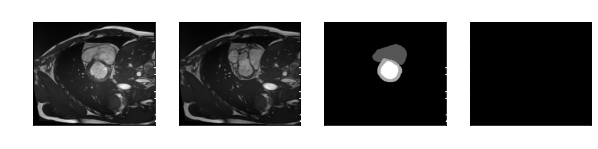

	ID: patient062, height: 172.0cm, weight: 74.0kg, group: NOR, nb_frames: 30


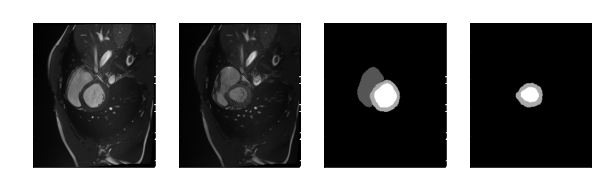

	ID: patient063, height: 165.0cm, weight: 49.0kg, group: NOR, nb_frames: 35


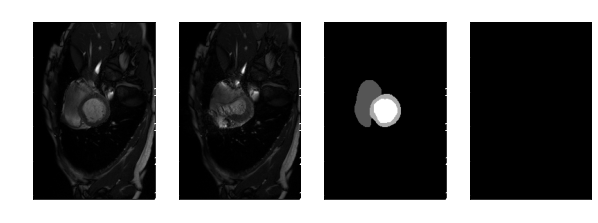

----------------------------------------------------------------------------------------------------

Group: Myocardial infarction

	ID: patient041, height: 170.0cm, weight: 70.0kg, group: MINF, nb_frames: 17


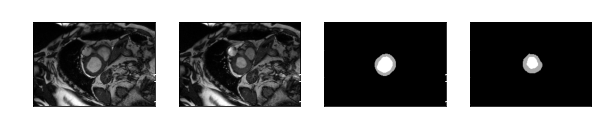

	ID: patient042, height: 168.0cm, weight: 99.0kg, group: MINF, nb_frames: 35


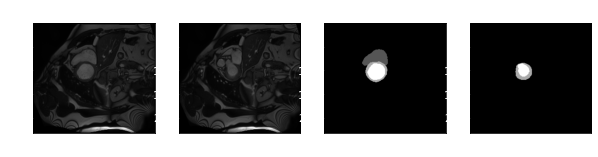

	ID: patient043, height: 165.0cm, weight: 76.0kg, group: MINF, nb_frames: 13


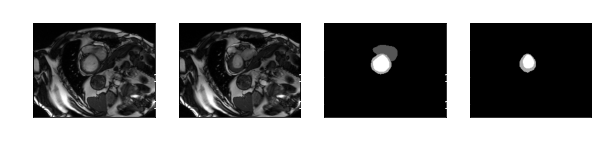

----------------------------------------------------------------------------------------------------

Group: Dilated cardiomyopathy

	ID: patient001, height: 184.0cm, weight: 95.0kg, group: DCM, nb_frames: 30


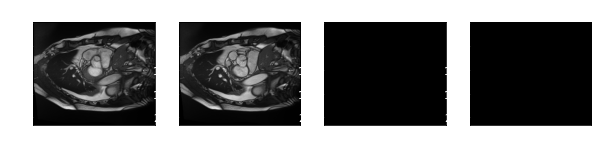

	ID: patient002, height: 160.0cm, weight: 70.0kg, group: DCM, nb_frames: 30


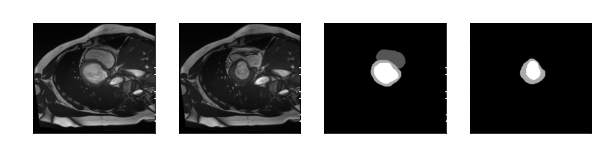

	ID: patient003, height: 165.0cm, weight: 77.0kg, group: DCM, nb_frames: 30


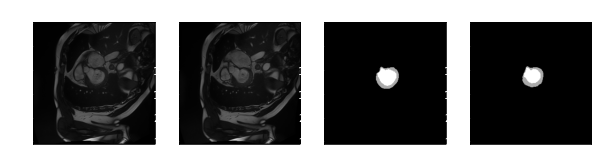

----------------------------------------------------------------------------------------------------

Group: Hypertrophic cardiomyopathy

	ID: patient021, height: 192.0cm, weight: 110.0kg, group: HCM, nb_frames: 30


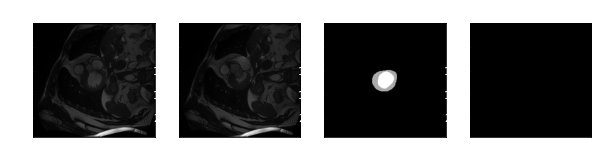

	ID: patient022, height: 165.0cm, weight: 42.0kg, group: HCM, nb_frames: 28


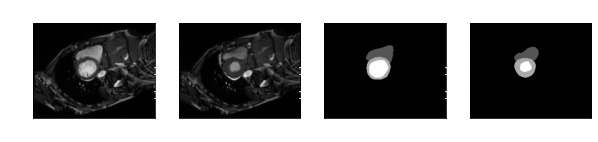

	ID: patient023, height: 166.0cm, weight: 74.0kg, group: HCM, nb_frames: 25


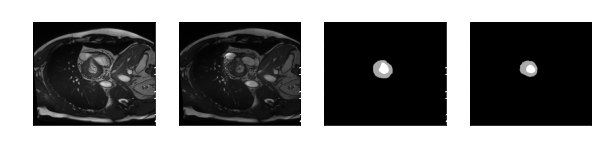

----------------------------------------------------------------------------------------------------

Group: Abnormal right ventricle

	ID: patient081, height: 177.0cm, weight: 70.0kg, group: RV, nb_frames: 16


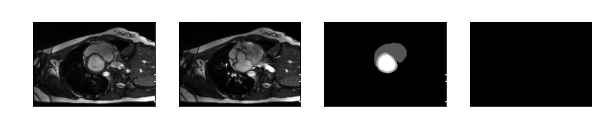

	ID: patient082, height: 183.0cm, weight: 82.0kg, group: RV, nb_frames: 17


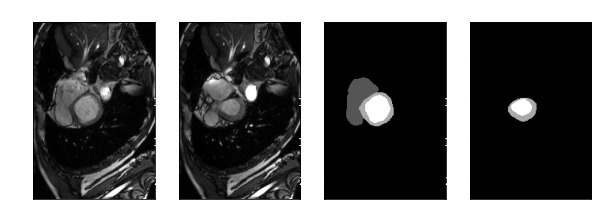

	ID: patient083, height: 160.0cm, weight: 58.0kg, group: RV, nb_frames: 17


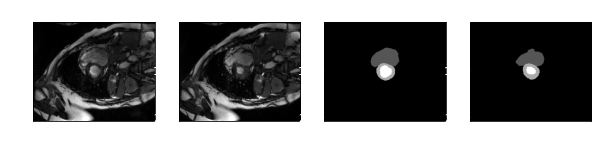

----------------------------------------------------------------------------------------------------



In [41]:
# Display examples for all groups
for group in group_map.keys():
    display_examples_for_group_train(group)
    print("-"*100 + "\n")